# Demonstration of the MA code's ability to decode social information from song

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import linear_model
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg, rand_string
from disp import set_plot, plot_b, colors
from my_stats import nanpearsonr

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

# Load natural song snippets

In [2]:
STRAINS = ['NM91', 'ZH23']
FSTRAIN = 'data/simple/strains.csv'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()

In [3]:
# load natural songs
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')[['ID', 'T', 'Q', 'S', 'P' ,'F']]
sngs_full = []
for itr in ISTRAIN:
    df_tr = df_song[df_song['ID'] == itr]
    sng_full = np.zeros(len(df_tr), dtype=int)
    sng_full[df_tr['S'] == 1] = 1
    sng_full[(df_tr['P'] == 1) | (df_tr['F'] == 1)] = 2
    sngs_full.append(sng_full)

In [4]:
def get_snippets(T_SNP, MIN_GAP, MIN_POWER=0, MAX_POWER=1):
    # get snippets
    nt_snp = int(round(T_SNP*FPS))
    t_snp = np.arange(nt_snp)*DT

    snps = []

    # go through all songs
    for ctr, sng_full in enumerate(sngs_full):
        
        segs, bds = get_seg(sng_full > 0, min_gap=int(round(MIN_GAP/DT)))
        
        segs = [sng_full[lb:ub] for lb, ub in bds]
        
        # keep fixed-length portions only of sufficiently long segments
        segs = [
            seg[:nt_snp] for seg in segs
            if (len(seg) >= nt_snp)
            and (np.mean(seg[:nt_snp] > 0) > MIN_POWER)
            and (np.mean(seg[:nt_snp] > 0) < MAX_POWER)
        ]
        
        snps.extend(segs)

    snps = np.array(snps)
    nsnp = len(snps)

    i_ss = [(snp == 1).astype(float) for snp in snps]
    i_ps = [(snp == 2).astype(float) for snp in snps]
    
    return snps, i_ss, i_ps

In [5]:
def smlt_v(i_s, i_p, tau_r, tau_a, x_s, x_p, dt, adapt='MA'):
    t = np.arange(len(i_s))*dt
    n = len(tau_a)
    
    vs = np.nan*np.zeros((len(t), n))
    vs[0, :] = 0
    
    rs = np.nan*np.zeros((len(t), n))
    rs[0, :] = 0
    
    a_ss = np.zeros((len(t), n))
    a_ps = np.zeros((len(t), n))
    
    for ct in range(1, len(t)):
        
        # update adapted input
        if adapt == 'MA':
            vs[ct, :] = x_s*(1-a_ss[ct-1, :])*i_s[ct] + x_p*(1-a_ps[ct-1, :])*i_p[ct]
        elif adapt == 'lin':
            vs[ct, :] = x_s*(i_s[ct]-a_ss[ct-1, :]) + x_p*(i_p[ct]-a_ps[ct-1, :])
        
        # update integral
        rs[ct, :] = rs[ct-1, :] + (DT/tau_r)*(-rs[ct-1, :] + vs[ct, :])
        
        # update adaptation variables
        da_s = (dt/tau_a)*(-a_ss[ct-1, :] + i_s[ct])
        a_ss[ct, :] = a_ss[ct-1, :] + da_s
        
        da_p = (dt/tau_a)*(-a_ps[ct-1, :] + i_p[ct])
        a_ps[ct, :] = a_ps[ct-1, :] + da_p
        
    return rs, vs, a_ss, a_ps, t

In [6]:
def get_basis(snps_basis, tau_r, tau_a, x_s, x_p, adapt, alpha):
    basis = np.nan*np.zeros((len(tau_r), len(isnps)))
    rs_full = []

    for csnp, snp in enumerate(snps_basis):
        i_s = (snp == 1).astype(float)
        i_p = (snp == 2).astype(float)

        t_snp = np.arange(len(snp))*DT

        rs = smlt_v(i_s, i_p, tau_r, tau_a, x_s, x_p, DT, adapt=adapt)[0]

        basis[:, csnp] = rs[-1, :]
        rs_full.append(rs)
        
    rgr = linear_model.Ridge(alpha=alpha, fit_intercept=False)
    w_readout = rgr.fit(basis.T, np.eye(len(isnps))).coef_.T
    
    return basis, w_readout, rs_full

In [7]:
def make_rand_chirp_song(z, chirp_basis, t_pause, t_total):
    
    pause = np.repeat(0, int(round(t_pause/DT)))
    
    sng_segs = [[]]
    t_chirps = []
    ichirps = []
    
    while len(cc(sng_segs))*DT < (t_total-t_pause):
        
        ichirp = np.random.choice(range(len(z)), p=z/z.sum())
        
        chirp = chirp_basis[ichirp]
        
        sng_segs.append(pause)
        sng_segs.append(chirp)
        
        t_chirps.append(DT*(len(cc(sng_segs)) - len(chirp)/2))
        ichirps.append(ichirp)
    
    sng_segs.append(pause)
    sng = cc(sng_segs)
    t_sng = np.arange(len(sng))*DT
    
    return sng, t_sng, t_chirps, ichirps

In [8]:
N = 20
tau_r = np.random.uniform(120, 120, N)
tau_a = np.random.uniform(.1, 2, N)
x_s = np.random.uniform(0, 1, N)
x_p = np.random.uniform(0, 1, N)
# minh = np.random.rand(N) < .5
# x_s[minh] *= -1
# x_p[minh] *= -1

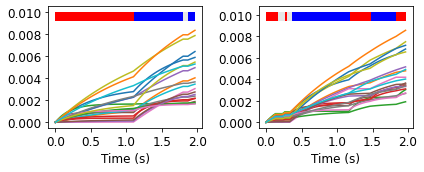

In [9]:
snps, i_ss, i_ps = get_snippets(T_SNP=2, MIN_GAP=3, MIN_POWER=0.5)
isnps = np.random.choice(range(len(snps)), 2, replace=False)
chirp_basis = [snps[isnp] for isnp in isnps]

ALPHA = 1e-9
basis_ma, w_ma, rs_full_ma = get_basis(chirp_basis, tau_r, tau_a, x_s, x_p, adapt='MA', alpha=ALPHA)
basis_lin, w_lin, rs_full_lin = get_basis(chirp_basis, tau_r, tau_a, x_s, x_p, adapt='lin', alpha=ALPHA)

fig, axs = plt.subplots(1, 2, figsize=(6, 2.5), tight_layout=True)

for csnp, isnp in enumerate(isnps):
    snp = snps[isnp]
    t_snp = np.arange(len(snp))*DT
    
    axs[csnp].plot(t_snp, rs_full_ma[csnp])
    plot_b(axs[csnp], t_snp, snp, [0, t_snp.max(), 1.1*rs_full_ma[csnp].max(), 1.2*rs_full_ma[csnp].max()], c=[(.9, .9, .9), 'b', 'r'])
    set_plot(axs[csnp], x_label='Time (s)')

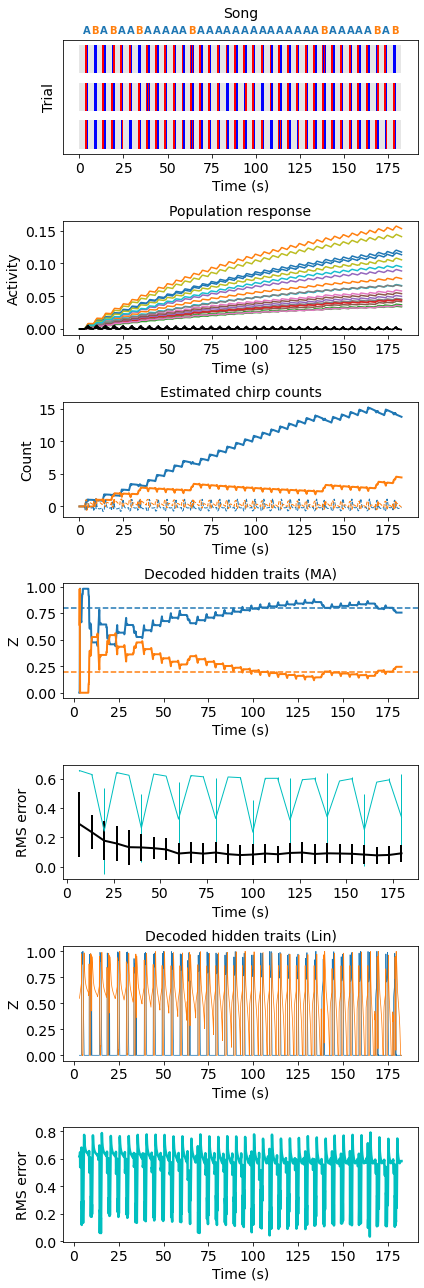

In [10]:
from disp import colors

Z = np.array([.8, .2])  # hidden information

T_PAUSE = 3
T_TOTAL = 180

NTR = 30

fig, axs = plt.subplots(7, 1, figsize=(6, 18), tight_layout=True)

rms_ma_all = []
rms_lin_all = []

for ctr in range(NTR):

    sng, t_sng, t_chirps, ichirps = make_rand_chirp_song(Z, chirp_basis, T_PAUSE, T_TOTAL)

    i_s = (sng == 1)
    i_p = (sng == 2)

    rs_ma = smlt_v(i_s, i_p, tau_r, tau_a, x_s, x_p, DT)[0]
    rs_lin = smlt_v(i_s, i_p, tau_r, tau_a, x_s, x_p, DT, adapt='lin')[0]
    
    # plot song
    if ctr < 3:
        plot_b(axs[0], t_sng, sng, [0, t_sng.max(), -ctr-.25, -ctr-1], c=[(.9, .9, .9), 'b', 'r'])
        set_plot(axs[0], y_label='Activation', title=f'Population response')
    
    if ctr == 0:
        for t_chirp, ichirp in zip(t_chirps, ichirps):
            axs[0].text(t_chirp, 0.05, ['A', 'B'][ichirp], color=colors[ichirp], ha='center', fontweight='bold')
    
    y_ma = rs_ma@w_ma
    y_lin = rs_lin@w_lin
    
    z_ma = np.clip(y_ma / np.abs(y_ma).sum(1)[:, None], 0, 1)
    z_lin = np.clip(y_lin / np.abs(y_lin).sum(1)[:, None], 0, 1)
    
    rms_ma = np.sqrt(np.mean((z_ma - Z[None, :])**2, axis=1))
    rms_lin = np.sqrt(np.mean((z_lin - Z[None, :])**2, axis=1))
    
    if ctr == 0:
        
        # plot MA responses
        axs[1].plot(t_sng, rs_ma)
        axs[1].plot(t_sng, rs_lin, c='k', lw=.5)

        # plot decoded chirp counts
        for w_ma_, color in zip(w_ma.T, colors):
            axs[2].plot(t_sng, rs_ma@w_ma_, lw=2, c=color)

        for w_lin_, color in zip(w_lin.T, colors):
            axs[2].plot(t_sng, rs_lin@w_lin_, lw=1, c=color, ls='--')

        # plot true Z
        for d, z in enumerate(Z):
            axs[3].axhline(z, color=colors[d], ls='--')
            
        # plot decoded Z
        for d in range(len(Z)):
            axs[3].plot(t_sng, z_ma[:, d], c=colors[d], lw=2)
            axs[5].plot(t_sng, z_lin[:, d], c=colors[d], lw=.75)
            
    # if ctr < 3:
        # plot estimation error
        # axs[4].plot(t_sng, rms_ma, c='gray', lw=.5)
        # axs[6].plot(t_sng, rms_lin, c='gray', lw=.5)
        
    rms_ma_all.append(rms_ma.copy())
    rms_lin_all.append(rms_lin.copy())

axs[6].plot(t_sng, np.mean(rms_lin_all, axis=0), c='c', lw=2.5)
# axs[4].plot(t_sng, np.mean(rms_lin_all, axis=0), c='c', lw=1.5)
# axs[4].plot(t_sng, np.mean(rms_ma_all, axis=0), c='k', lw=2.5)
step = 200
axs[4].errorbar(t_sng[::step], np.mean(rms_lin_all, axis=0)[::step], yerr=np.std(rms_lin_all, axis=0)[::step], c='c', lw=1)
axs[4].errorbar(t_sng[::step], np.mean(rms_ma_all, axis=0)[::step], yerr=np.std(rms_ma_all, axis=0)[::step], c='k', lw=2)
        
    
set_plot(axs[0], y_ticks=[], y_label='Trial', title='Song\n')
set_plot(axs[1], y_label='Activity', title='Population response')
set_plot(axs[2], y_label='Count', title='Estimated chirp counts')
set_plot(axs[3], y_label='Z', title='Decoded hidden traits (MA)')
set_plot(axs[4], y_label='RMS error')
set_plot(axs[5], y_label='Z', title='Decoded hidden traits (Lin)')
set_plot(axs[6], y_label='RMS error')

for ax in axs:
    set_plot(ax, x_label='Time (s)', font_size=14)

fig.savefig('ms/fig_5_social_info_demo.svg')